# Brain MRI Segmentation
***Predict Brain Tissue Segmentation Masks from Brain MRI Scans***

## Contents

1. [Background](#Background)
1. [Exploratory Data Analyis & Pre-processing](#Exploratory-Data-Analysis-&-Pre-processing)
1. [Train Models on Sagemaker](#Train-Models-on-SageMaker)
1. [Inference Endpoints](#Inference-Endpoints)
1. [Model Evaluation](#Model-Evaluation)
1. [Extensions](#Extensions)

## Background

This notebook shows how to apply image segmentation algorithms to medical imaging use-cases in a simple, streamlined way using Amazon SageMaker. Specifically, we'll be using Apache MXNet to train a convolutional neural network for semantic segmentation on SageMaker using the "Bring Your Own Script" paradigm. Put simply, the goal of semantic segmentation is to make classifications on an image at the pixel-level, producing a classification "mask." We will train two networks, U-Net and ENet. We'll show how to deploy these models to inference endpoints, both in the cloud on Amazon SageMaker and at the edge using AWS GreenGrass.

### Use-case

Medical imaging techniques allow medical professionals to see inside the human body, but more often than not the professional needs precise segmentation of the tissues within the image for analytical procedures and inferences. This is particular relevant in use-cases where volumetric and surface analysis are key to derive insights from the raw imaging, such as assessing the cardivascular health of a patient. Typically, this segmentation is done manually by medical professionals, and is very time consuming. Recently, convolutional neural networks have been shown to be highly performant at this task, and in this notebook we'll train two such networks to automatically segment brain tissue from MRI images.

### CNN Architectures

In this notebook, we apply two models to the task of brain tissue segmentation:
* **U-Net**: Introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597), this network was originally used for medical-imaging use-cases but has since proven to be reliable in generic segmentation domains. Due to it's architectural and conceptual simplicity, its often used as a baseline.
* **ENet**: Introduced in the paper [ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation](https://arxiv.org/abs/1606.02147), ENet is designed to be low-latency and to operate in environments with low compute capacity (e.g. edge devices). Compared to existing architectures, ENet optimizes for processing time over accuracy.

### Dataset

In this notebook, we'll be using Brain MRI data from the [Open Access Series of Imaging Studies (OASIS)](http://www.oasis-brains.org/). This project offers a wealth of neuroimaging datasets; we'll be looking at a small subset of cross-sectional brain MRIs.

**Note:** You need to request access on the OASIS site to get the data. In this tutorial, I'll be using the <tt>disc1.tar.gz</tt> file from the [OASIS-1](http://www.oasis-brains.org/#data) data set.

## Exploratory Data Analysis & Pre-processing

In this section, we'll visualize the data and pre-process it for training a segmentation network. Once completed, we'll put the pre-processed data on S3 for SageMaker to use during model training.

### Setup

We'll start by importing the libraries necessary to perform the data visualization and pre-processing.

In [311]:
import numpy as np
from PIL import Image
import boto3
import os
from glob import glob
import imageio
from sklearn.cross_validation import train_test_split
import time
import urllib
import tarfile
import shutil
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Download & Extract
Next, we're going to download the compressed data file locally and extract it to our data directory. I've put the <tt>disc1.tar.gx</tt> file in S3 and will download it from there.

I've left the data directory up to you, because depending on your instance type you may or may not have the disk space to download and extract this data set. Some options:
* Download data to the shared memory at <tt>/dev/shm</tt> if you have enough storage capacity there. Data saved here is not persistent, but we're only pre-processing and putting data on S3.
* [Mount an Elastic File System to this instance.](https://aws.amazon.com/blogs/machine-learning/mount-an-efs-file-system-to-an-amazon-sagemaker-notebook-with-lifecycle-configurations/) This is useful if you want your data to persist in a file system accessible by your instance.

In [239]:
data_bucket = '<YOUR-S3-BUCKET>'
data_prefix = '<YOUR-S3-PREFIX>'
data_dir = '<YOUR-DATA-DIR>'

In [400]:
def create_dir_if_not_exist(d):
    if not os.path.exists(d):
        os.mkdir(d)

Now we can download and extract.

In [250]:
create_dir_if_not_exist(os.path.join(data_dir, 'brain_mri'))
boto3.client('s3').download_file(
    Bucket=data_bucket,
    Key=data_prefix,
    Filename=os.path.join(data_dir, "brain_mri", "disc1.tar.gz")
)
with tarfile.open(os.path.join(data_dir, "brain_mri", "disc1.tar.gz")) as tar:
    tar.extractall(os.path.join(data_dir, 'brain_mri'))

### Visualization

Let's load a cross-sectional brain MRI into memory. Although organ tissue segmentation is inherently a three-dimensional task, we’ll approximate it by segmenting 2-D cross-sectional MRI slices. This is less complex and compute-intensive than volumetric segmentation and performs reasonably well.

Let's look at such a slice:

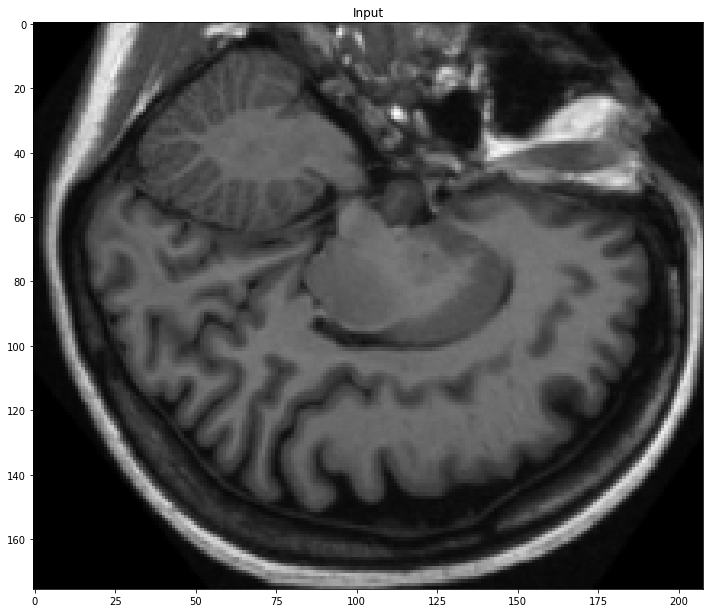

In [478]:
image = np.fromfile(
    open(os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','PROCESSED','MPRAGE','T88_111','OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img'), 'rb'),
    np.dtype('>u2')).reshape((176, 208, 176))

plt.figure(figsize=(12, 12))
plt.title('Input')
plt.imshow(image[:, :, 101], cmap=plt.cm.gray)

In order to train a segmentation network, we need ground-truth segmentation masks for the tissue. Fortunately, the data set comes with such masks hand-annotated by medical professionals:

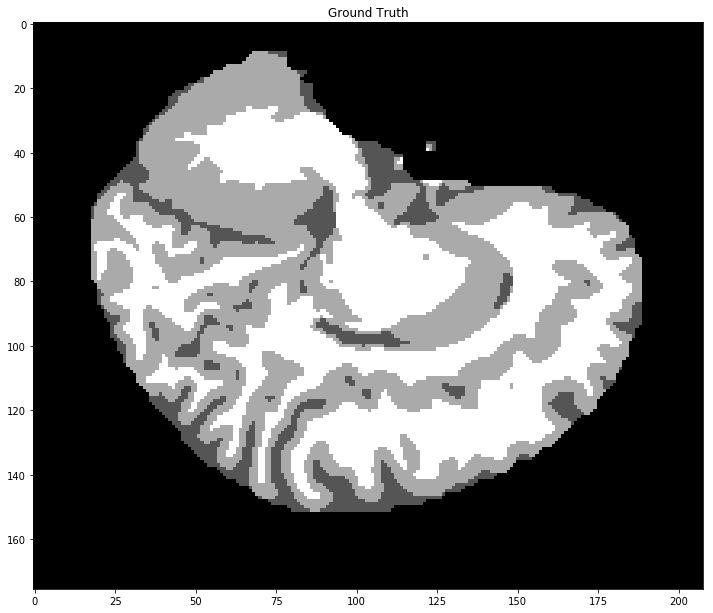

In [477]:
segmentation = np.fromfile(
    open(os.path.join(data_dir, 'brain_mri','disc1','OAS1_0002_MR1','FSL_SEG','OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img'), 'rb'),
    np.dtype('>u2')).reshape((176, 208, 88))

plt.figure(figsize=(12, 12))
plt.title('Ground Truth')
plt.imshow(segmentation[:, :, 50], cmap=plt.cm.gray)

### Pre-processing

Now that we've seen the data, we need to pre-process it to train our network on it. 

First, we're going to split the data into a training and validation set (80/20) **by patient**. This is important to remove any possibility of **data leakage**; neighboring brain MRI slices will correlate and splitting by patient ensures clean validation.

In [ ]:
images = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*','*','*','t88_gfc.img'))
masks = glob(os.path.join(data_dir, 'brain_mri','disc1','*','*','*t88_masked_gfc_fseg.img'))
images.sort()
masks.sort()
train_images, validation_images, train_masks, validation_masks = train_test_split(
images, masks, test_size=0.2, random_state=1984)

Next, we're going to load each image and mask slice into memory, pre-process them, and save them to disk as individual image files into respective training and validation directories.

In [300]:
processed_data_dir = os.path.join(data_dir, 'brain_mri', 'data')
train_dir = os.path.join(processed_data_dir, 'train')
validation_dir = os.path.join(processed_data_dir, 'validation')

create_dir_if_not_exist(processed_data_dir)
create_dir_if_not_exist(train_dir)
create_dir_if_not_exist(validation_dir)

In order to pre-process the MRI images, we need to convert them from their native format to arrays that we can save as png images. 

The raw MRI arrays have values that represent radiological intensities. These have a far wider range than pixel intensities, and are loaded into memory as uint16. Upon saving the slices as png's, the data is scaled to fall on the \[0,255\] range of uint8.

**Note**: This scaling can result in differences between tissue pixel distributions from image to image, but this doesn't prove to be a problem.

In [301]:
def process_mris(files, target_dir):
    for f in files:
        mris = np.fromfile(open(f, 'rb'), dtype='>u2')\
            .reshape((176, 208, 176))[:, :, np.arange(1, 176, 2)].transpose((2, 0, 1))
        for i, mri in enumerate(mris):
            new_fname = "_".join(os.path.basename(f).split('.')[0].split('_')[:8])+"_%i.png" % i
            if np.max(mri) <= 255:
                imageio.imsave(os.path.join(target_dir, new_fname), mri.astype(np.uint8))
            else:
                imageio.imsave(os.path.join(target_dir, new_fname), mri)
    return

In [302]:
process_mris(train_images, train_dir)
process_mris(validation_images, validation_dir)

For the masks, we need to save the raw masks as images with exactly one pixel per tissue class. The pixel values of the raw images are not exact, and so each raw mask's pixel values are mapped to a specific integer.

In [303]:
def bin_mask(raw_segmentation):
    raw_segmentation[raw_segmentation <= 150] = 0
    raw_segmentation[np.where((150 < raw_segmentation) & (raw_segmentation <= 400))] = 1
    raw_segmentation[np.where((400 < raw_segmentation) & (raw_segmentation <= 625))] = 2
    raw_segmentation[raw_segmentation > 625] = 3
    return raw_segmentation


def process_labels(files, target_dir):
    for f in files:
        tmp = np.fromfile(open(f, 'rb'), dtype='>u2').reshape(
            (176, 208, 88)).transpose((2, 0, 1))
        masks = bin_mask(tmp)
        for i, mask in enumerate(masks):
            new_fname = "_".join(os.path.basename(f).split('.')[0].split('_')[:8])+"_%i_mask.png" % i
            imageio.imsave(os.path.join(target_dir, new_fname), mask.astype(np.uint8))
    return

In [304]:
process_labels(train_masks, train_dir)
process_labels(validation_masks, validation_dir)

Note that in both steps, we saved the files under a specific naming convention. This is so the I/O iterators we'll use to load the data know how to pair the images and masks.

### Sample, Distributed Sets

Now that we've pre-processed our data, we're going to make two additional data sets from this:
* Sample data for testing our algorithm locally
* 50-50 split of the training data for distributed training

To do this, we'll grab all image, mask pairs.

In [310]:
train_pairs = [(img, img.split('.')[0]+'_mask.png')
               for img in os.listdir(train_dir) if 'mask' not in img]
validation_pairs = [(img, img.split('.')[0]+'_mask.png')
                    for img in os.listdir(validation_dir) if 'mask' not in img]

We'll sample 20% of the training and validation data.

In [459]:
sample_train_indices = np.random.choice(range(len(train_pairs)), size=10, replace=False)
sample_validation_indices = np.random.choice(range(len(validation_pairs)), size=10, replace=False)
sample_train_pairs = np.array(train_pairs)[sample_train_indices]
sample_validation_pairs = np.array(validation_pairs)[sample_validation_indices]

And save to sample directories:

In [460]:
sample_train_dir = os.path.join(processed_data_dir, 'sample-train')
sample_validation_dir = os.path.join(processed_data_dir, 'sample-validation')

create_dir_if_not_exist(sample_train_dir)
create_dir_if_not_exist(sample_validation_dir)

for f in sample_train_pairs.flatten():
    shutil.copy(os.path.join(train_dir, f), os.path.join(sample_train_dir, f))
for f in sample_validation_pairs.flatten():
    shutil.copy(os.path.join(validation_dir, f),
                os.path.join(sample_validation_dir, f))

Next, we'll split the training data in two, which we'll use in a distributed training example later.

In [ ]:
distributed_train_indices = np.random.choice(range(len(train_pairs)), size=int(0.5*len(train_pairs)), replace=False)

dist_train_one_pairs = np.array(train_pairs)[distributed_train_indices]
dist_train_two_pairs = np.array(train_pairs)[[i for i in range(len(train_pairs))\
                                              if i not in distributed_train_indices]]

dist_dir = os.path.join(processed_data_dir, 'distributed-training')
dist_train_one_dir = os.path.join(dist_dir, 'dist-train-one')
dist_train_two_dir = os.path.join(dist_dir, 'dist-train-two')

create_dir_if_not_exist(dist_dir)
create_dir_if_not_exist(dist_train_one_dir)
create_dir_if_not_exist(dist_train_two_dir)

for f in dist_train_one_pairs.flatten():
    shutil.copy(os.path.join(train_dir, f),
                os.path.join(dist_train_one_dir, f))
for f in dist_train_two_pairs.flatten():
    shutil.copy(os.path.join(train_dir, f),
                os.path.join(dist_train_two_dir, f))

Now that we've generated the data splits we need, let's bundle and compress the data:

In [393]:
tar_gz_dir = os.path.join(data_dir, 'tar_gz')
tar_gz_train_dir = os.path.join(tar_gz_dir, "train")
tar_gz_validation_dir = os.path.join(tar_gz_dir, "validation")
tar_gz_sample_train_dir = os.path.join(tar_gz_dir, "sample-train")
tar_gz_sample_validation_dir = os.path.join(tar_gz_dir, "sample-validation")
tar_gz_dist_dir = os.path.join(tar_gz_dir, 'dist')

create_dir_if_not_exist(tar_gz_dir)
create_dir_if_not_exist(tar_gz_train_dir)
create_dir_if_not_exist(tar_gz_validation_dir)
create_dir_if_not_exist(tar_gz_sample_train_dir)
create_dir_if_not_exist(tar_gz_sample_validation_dir)
create_dir_if_not_exist(tar_gz_dist_dir)

with tarfile.open(os.path.join(tar_gz_train_dir, "train.tar.gz"), "w:gz") as tar:
    tar.add(train_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_validation_dir, "validation.tar.gz"), "w:gz") as tar:
    tar.add(validation_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_sample_train_dir, "sample-train.tar.gz"), "w:gz") as tar:
    tar.add(sample_train_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_sample_validation_dir, "sample-validation.tar.gz"), "w:gz") as tar:
    tar.add(sample_validation_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_dist_dir, "dist-train-one.tar.gz"), "w:gz") as tar:
    tar.add(dist_train_one_dir, arcname='')
with tarfile.open(os.path.join(tar_gz_dist_dir, "dist-train-two.tar.gz"), "w:gz") as tar:
    tar.add(dist_train_two_dir, arcname='')

Now we're ready to put this data on S3 and start training our models.

## Train Models on SageMaker

### Setup

We'll begin by importing the SageMaker python SDK. We're going to define:
* Session object that provides convenience methods within the context of SageMaker and our own account.
* SageMaker role ARN used to delegate permissions to the training and hosting service. We need this so these services can access the S3 buckets where your data and model is stored.

We'll also import the sagemaker <tt>MXNet</tt> estimator object. This object references default containers that AWS provides, and users provide only entry points and supporting code. This is known as "Bring Your Own Script."

In [394]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = get_execution_role()

### Upload data

Next, we're going to upload the pre-processed data to S3 using the <tt>upload_data</tt> method to put the objects in a default SageMaker bucket. We're going to pass the parent directory containing the compressed files to the method, which syncs the child tree to the bucket.

In [462]:
prefix = 'brain-segmentation-tar-gz'
data_bucket = sagemaker_session.upload_data(path=tar_gz_dir, key_prefix=prefix)

### Entry Point

As mentioned, the <tt>MXNet</tt> estimator uses a default MXNet container and the user simply provides the code that defines the training.

The script we'll be passing as an entry point to the estimator is <tt>brain_segmentation.py</tt>:

In [6]:
!cat source_dir/brain_segmentation.py

import os
import tarfile
import mxnet as mx
import numpy as np
from iterator import DataLoaderIter
from losses_and_metrics import avg_dice_coef_metric
from models import build_unet, build_enet
import logging

logging.getLogger().setLevel(logging.DEBUG)

###############################
###     Training Loop       ###
###############################

def train(current_host, channel_input_dirs, hyperparameters, hosts, num_cpus, num_gpus):
    
    logging.info(mx.__version__)
    
    # Set context for compute based on instance environment
    if num_gpus > 0:
        ctx = [mx.gpu(i) for i in range(num_gpus)]
    else:
        ctx = mx.cpu()

    # Set location of key-value store based on training config.
    if len(hosts) == 1:
        kvstore = 'device' if num_gpus > 0 else 'local'
    else:
        kvstore = 'dist_device_sync' if num_gpus > 0 else 'dist_sync'
    
    # Get hyperparameters
    batch_size = hyperparameters.get('batch_size', 16)        
    learning_rate = hyperparamete

We can see that this script defines the training loop, which constitutes the life-cycle of the training job. Some points to notice:
* **hyperparameters**: This hyperparameter mapping is something that we'll pass to the estimator as part of the training configuration.
* **network**: This hyperparameter defines the network to train, either <tt>unet</tt> or <tt>enet</tt>.
* **local imports**: The model, iterator, and loss/metric definitions are in local modules. We will pass this script, as well as accompanying modules, to the estimator

I encourage you to look at these modules for deeper insights into training these networks.

### Local Testing using Local Mode

SageMaker manages the resources and infrastructure necessary to run your training jobs, but when bringing your own script or model it is up to you to ensure that your code is bug-free. 

It's best practice to test your custom algorithm container locally, otherwise you'll have to wait for SageMaker to spin up your training instance(s) before receiving an error. SageMaker supports this with **Local Mode**.

To run the container locally, you need to download, install, and configure docker to run locally with SageMaker. You can download the helper script below to do this:

In [ ]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/mxnet_gluon_mnist/setup.sh
!/bin/bash ./setup.sh

Next, we define the S3 input types.

In [463]:
sample_train_s3 = sagemaker.s3_input(s3_data=os.path.join(
    data_bucket, "sample-train"), distribution='FullyReplicated')
sample_validation_s3 = sagemaker.s3_input(s3_data=os.path.join(
    data_bucket, "sample-validation"), distribution='FullyReplicated')

Now we can define our estimator with training configurations, including the entry point script and directory for accompanying code. Notice we're setting <tt>train_instance_type</tt> to <tt>local</tt>.

In [464]:
local_unet_job = 'DEMO-local-unet-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

local_estimator = MXNet(entry_point='brain_segmentation.py',
                        base_job_name=local_unet_job,
                        source_dir='source_dir',
                        role=role,
                        train_instance_count=1,
                        train_instance_type='local',
                        hyperparameters={
                            'learning_rate': 1E-3 * 16,
                            'class_weights': [[1.35, 17.18,  8.29, 12.42]],
                            'network': 'unet',
                            'batch_size': 8,
                            'epochs': 1
                        })

Now we call <tt>fit</tt> on the S3 inputs, mapping <tt>train</tt> and <tt>test</tt> labels to each. Since we're in local mode, the container will be downloaded and ran locally.

In [ ]:
local_estimator.fit({'train': sample_train_s3, 'test': sample_validation_s3})

Next, we can test the serving image locally as well by calling <tt>deploy</tt>.

In [ ]:
local_unet_endpoint = 'DEMO-local-unet-endpoint-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

local_predictor = local_estimator.deploy(initial_instance_count=1, instance_type='local',
                                         endpoint_name=local_unet_endpoint)

The <tt>deploy</tt> method returns a <tt>predictor</tt>, which we can use to submit requests to the endpoint. An endpoint is a containerized application serving inference using your model artifact, which we'll test locally.

Let's load a test image into memory to submit for inference:

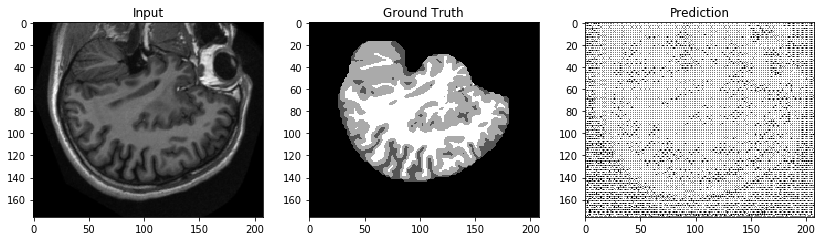

In [485]:
test_brain = np.array(Image.open(os.path.join(
    validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_26.png')))[np.newaxis, np.newaxis, :]
test_mask = np.array(Image.open(os.path.join(
    validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_26_mask.png')))[np.newaxis, np.newaxis, :]

response = local_predictor.predict(test_brain.tolist())
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
plt.imshow(output, cmap=plt.cm.gray)

The result is predictably terrible, given the small sample set and one epoch of training.

Now that we've tested our images, we can launch training jobs and endpoints.

### UNet 

We'll first train U-Net as a baseline for comparison with the faster, lightweight ENet.

In [224]:
unet_single_machine_job = 'DEMO-unet-single-machine-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

unet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                      base_job_name=unet_single_machine_job,
                                      source_dir='source_dir',
                                      role=role,
                                      train_instance_count=1,
                                      train_instance_type='ml.p3.2xlarge',
                                      hyperparameters={
                                          'learning_rate': 1E-3,
                                          'class_weights': [[1.35, 17.18,  8.29, 12.42]],
                                          'network': 'unet',
                                          'batch_size': 32,
                                      })

This time, we'll train on the entire training set, and validate on the entire validation set.

In [479]:
train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "train"), distribution='FullyReplicated')
validation_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "validation"), distribution='FullyReplicated')

unet_single_machine_estimator.fit({'train': train_s3, 'test': validation_s3})

### ENet

Next, we'll train ENet.

In [ ]:
enet_single_machine_job = 'DEMO-enet-single-machine-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

enet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                      base_job_name=enet_single_machine_job,
                                      source_dir='source_dir',
                                      role=role,
                                      train_instance_count=1,
                                      train_instance_type='ml.p3.2xlarge',
                                      hyperparameters={
                                          'learning_rate': 1E-3,
                                          'class_weights': [[1.35, 17.18,  8.29, 12.42]],
                                          'network': 'enet',
                                          'batch_size': 32,
                                      })

enet_single_machine_estimator.fit({'train': train_s3, 'test': validation_s3})

## Inference Endpoints

Now that we've trained both models, let's deploy to endpoints to serve inference and compare performance.

### U-Net Endpoint

In [230]:
unet_endpoint = 'DEMO-unet-endpoint-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

unet_predictor = unet_single_machine_estimator.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                                      endpoint_name=unet_endpoint)

Let's get a test response.

In [487]:
response = unet_predictor.predict(test_brain.tolist())

Compare with input and ground truth.

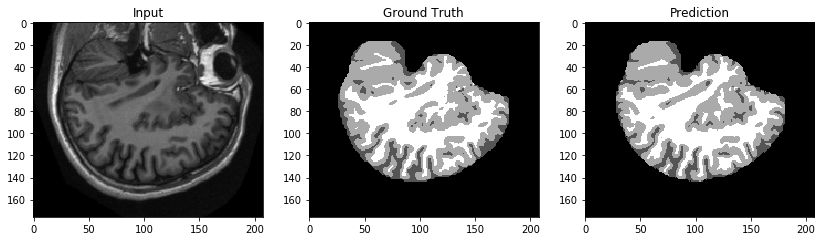

In [488]:
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
plt.imshow(output, cmap=plt.cm.gray)

### ENet Endpoint

Now let's deploy our ENet model. 

Instead of using <tt>estimator</tt>'s <tt>deploy</tt> method, as an exercise we'll create a model object <tt>MXNetModel</tt> instead. We'll pass the location of the ENet model artifact from the training job; this is how you would "bring your own model" to SageMaker to deploy to an endpoint.

In [546]:
enet_endpoint = 'DEMO-enet-endpoint-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
enet_model = sagemaker.mxnet.MXNetModel(enet_single_machine_estimator.model_data, role, 'brain_segmentation.py',
                                        source_dir='source_dir', framework_version="1.0")

enet_predictor = enet_model.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1)

Let's get a test response.

In [554]:
response = enet_predictor.predict(test_brain.tolist())

Compare with input and ground truth.

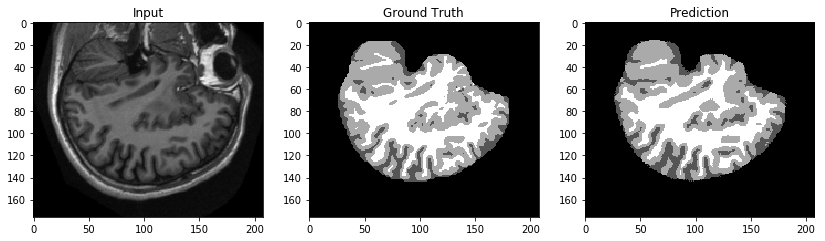

In [555]:
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
plt.imshow(output, cmap=plt.cm.gray)

Qualitatively, these results look good. Let's quantitate this performance.

## Model Evaluation

We're going to simultaneously visualize and quantify model performance using confusion matrices. To do this, we'll use this function to plot the matrix:

In [566]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#Citations
#@article{scikit-learn,
# title={Scikit-learn: Machine Learning in {P}ython},
# author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
#         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
#         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
#         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
# journal={Journal of Machine Learning Research},
# volume={12},
# pages={2825--2830},
# year={2011}
#}

### U-Net

We'll get predictions from our validation images, and load validation ground truths into memory as well.

In [561]:
ground_truths = []
outputs = []
for validation_pair in validation_pairs:
    img = np.array(Image.open(os.path.join(validation_dir, validation_pair[0])))[
        np.newaxis, np.newaxis, :]
    response = unet_predictor.predict(img.tolist())
    outputs.append(np.argmax(np.array(response), axis=(1))[0].astype(np.uint8))
    ground_truths.append(
        np.array(Image.open(os.path.join(validation_dir, validation_pair[1]))))
ground_truths = np.concatenate(ground_truths)
outputs = np.concatenate(outputs)
ground_truths = ground_truths.flatten()
outputs = outputs.flatten()

Now, we can compare the predictions to the ground truth labels.

Confusion matrix, without normalization
[[18995250    65634    25070     1606]
 [  100009  1017951   179977      741]
 [   40586   157985  2876666   176794]
 [    5804      382   218008  1909569]]
Normalized confusion matrix
[[  9.95e-01   3.44e-03   1.31e-03   8.41e-05]
 [  7.70e-02   7.84e-01   1.39e-01   5.71e-04]
 [  1.25e-02   4.86e-02   8.85e-01   5.44e-02]
 [  2.72e-03   1.79e-04   1.02e-01   8.95e-01]]


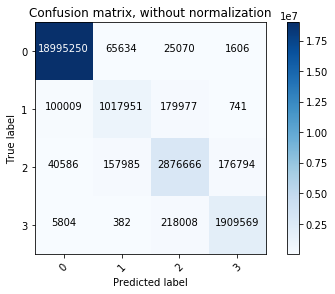

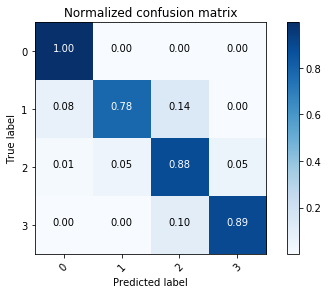

In [567]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, outputs)
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ENet

We'll get predictions from our validation images, and load validation ground truths into memory as well.

In [568]:
ground_truths = []
outputs = []
for validation_pair in validation_pairs:
    img = np.array(Image.open(os.path.join(validation_dir, validation_pair[0])))[np.newaxis, np.newaxis, :]
    response = enet_predictor.predict(img.tolist())
    outputs.append(np.argmax(np.array(response), axis=(1))[0].astype(np.uint8))
    ground_truths.append(np.array(Image.open(os.path.join(validation_dir, validation_pair[1]))))
ground_truths = np.concatenate(ground_truths)
outputs = np.concatenate(outputs)
ground_truths = ground_truths.flatten()
outputs = outputs.flatten()

Now, we can compare the predictions to the ground truth labels.

Confusion matrix, without normalization
[[18904449   135519    45407     2185]
 [   62923  1073005   161792      958]
 [   21984   323708  2711161   195178]
 [    3507     4086   336629  1789541]]
Normalized confusion matrix
[[  9.90e-01   7.10e-03   2.38e-03   1.14e-04]
 [  4.85e-02   8.26e-01   1.25e-01   7.38e-04]
 [  6.76e-03   9.95e-02   8.34e-01   6.00e-02]
 [  1.64e-03   1.91e-03   1.58e-01   8.39e-01]]


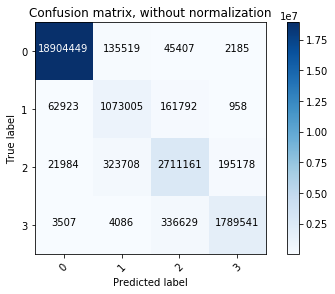

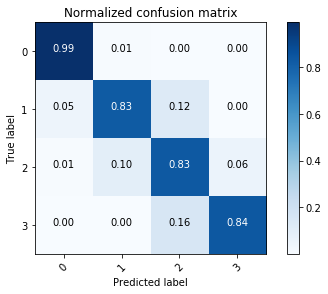

In [569]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, outputs)
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**Note**: To avoid unnecessary usage, make sure to delete your endpoints.

In [ ]:
unet_single_machine_estimator.delete_endpoint()
sagemaker_session.delete_endpoint(enet_model.endpoint_name)

## Extensions

### Distributed Training

The data that we've trained on is a very small subset of what's available at OASIS. When training at scale, it's often the case that distributed training is a more cost-effective approach to training your network than vertical scaling, both from a time and dollar cost perspective.

Here we demonstrate how simple it is to launch a distributed training job on SageMaker:

1. The script we provide must support distributed training (looking back at the entry point, note the management of the key-value store that supports synchronous distributed training in a multi-device environment).
2. Set <tt>train_instance_count</tt> from one to many.
3. Shard training data across nodes.

For the latter, we define a sharded S3 input by setting <tt>distribution</tt> to <tt>ShardedByS3Key</tt>. This option will attempt to evenly split the number of objects under the provided pre-fix across nodes (this implicitly means you need as many objects under the prefix as nodes). Had we kept this argument as <tt>FullyReplicated</tt>, each node would have copies of the entire data set.

We've put two compressed data sets under this prefix.

In [480]:
distributed_train_s3 = sagemaker.s3_input(s3_data=os.path.join(
    data_bucket, "dist"), distribution='ShardedByS3Key')

Now we can launch a distributed training job.

In [19]:
unet_distributed_job = 'DEMO-unet-distributed-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

unet_distributed_estimator = MXNet(entry_point='brain_segmentation.py',
                                   base_job_name=unet_distributed_job,
                                   source_dir='source_dir',
                                   role=role,
                                   train_instance_count=2,
                                   train_instance_type='ml.p3.2xlarge',
                                   hyperparameters={
                                       'epochs': 50,
                                       'learning_rate': 1E-3,
                                       'class_weights': [[1.35, 17.18,  8.29, 12.42]],
                                       'network': 'unet',
                                       'batch_size': 32,
                                   })

unet_distributed_estimator.fit({'train': distributed_train_s3,
                                'test': validation_s3})

This may or may not actually be faster than the single machine training at this scale, but at larger scale distributed training is key.

### Endpoint Invocation w/ S3

MXNet SageMaker endpoints are by default set up to run inference on data sent via POST request, with the assumption that the data sent is in the format of the data the model is trained on. For computer vision models, this can be problematic due to the bandwidth limits on SageMaker requests. 

One workaround is to instead submit an S3 URI, have the endpoint download the model locally, transform, and put the resulting mask back to S3. In this approach, there is no limit to the size of the content transformed.

Let's take a look at the entry point for this hosting script:

In [7]:
!cat source_dir/brain_segmentation_s3_transform.py

from __future__ import absolute_import
import boto3
import base64
import json
import io
import os
import mxnet as mx
from mxnet import nd
import numpy as np
mx.test_utils.download("https://s3.amazonaws.com/sagemaker-png/png.py", "png.py")
import png

###############################
###     Hosting Code        ###
###############################

def push_to_s3(img, bucket, prefix):
    """
    A method for encoding an image array as png and pushing to S3

    Parameters
    ----------
    img : np.array
        Integer array representing image to be uploaded.
    bucket : str
        S3 Bucket to upload to.
    prefix : str
        Prefix to upload encoded image to (should be .png).
    """
    s3 = boto3.client('s3')
    png.from_array(img.astype(np.uint8), 'L').save('img.png')
    response = s3.put_object(
        Body=open('img.png', 'rb'),
        Bucket=bucket,
        Key=prefix
    )
    return

def download_from_s3(bucket, prefix):
    """
    A method for downloading object fr

Since we already have a trained model, we'll directly define the <tt>model</tt> object using <tt>MXNetModel</tt> w/ the S3 location of our model artifact from the earlier training job. This is how you would "bring your own model" to SageMaker to deploy to an endpoint.

In [571]:
unet_s3_endpoint = 'DEMO-unet-s3-endpoint-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

unet_s3_model = sagemaker.mxnet.MXNetModel(unet_single_machine_estimator.model_data, role,
                                           entry_point="brain_segmentation_s3_transform.py", source_dir='source_dir')

unet_s3_predictor = unet_s3_model.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                         endpoint_name=unet_s3_endpoint)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-06-20-07-06-04-159
INFO:sagemaker:Creating endpoint with name DEMO-unet-s3-endpoint-2018-06-20-07-06-03


---------------------------------------------------!

Let's upload our test image to S3:

In [576]:
s3 = boto3.client('s3')
test_bucket = "<YOUR-BUCKET-HERE>"
prefix = "test_img.png"
s3.upload_file(Filename=os.path.join(validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_26.png'),
               Bucket=test_bucket, Key=prefix)

The body of our request will be in JSON format, so we'll define a dict containing the relevant fields and invoke the endpoint:

In [585]:
request_body = json.dumps({"bucket": test_bucket, "prefix": prefix})

response = unet_s3_predictor.predict([request_body])

Now let's download the result:

In [589]:
s3.download_file(Bucket=response['bucket'],
                 Key=response['prefix'], Filename="result.png")

plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
plt.imshow(np.array(Image.open("result.png")), cmap=plt.cm.gray)

### Train Model for Raspberry Pi Deployment w/ AWS Greengrass ML Inference

Currently, the only MXNet binary available for RPI through AWS is version 0.11. There's no native support for this version through the sdk, so we're going to define an estimator as usual and then manually set the training image to a container with MXNet 0.11.

In [147]:
enet_eleven_job = 'DEMO-enet-eleven-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

enet_eleven_estimator = MXNet(entry_point='brain_segmentation.py',
                              base_job_name=enet_eleven_job,
                              source_dir='source_dir',
                              role=role,
                              train_instance_count=1,
                              train_instance_type='ml.p3.2xlarge',
                              hyperparameters={
                                  'learning_rate': 1E-3,
                                  'class_weights': [[1.35, 17.18,  8.29, 12.42]],
                                  'network': 'enet',
                                  'batch_size': 32,
                              })

region = sagemaker_session.boto_session.region_name
enet_eleven_estimator.train_image = lambda: '780728360657.dkr.ecr.{}.amazonaws.com/sagemaker-mxnet-py2-gpu:1.0'.format(
    region)

Once set, the model is fit as usual.

In [ ]:
enet_eleven_estimator.fit({'train': train_s3, 'test': validation_s3})

Once trained, take note of the model location. You'll use this artifact as an ML Resource for Greengrass deployment.

In [151]:
enet_eleven_estimator.model_data

u's3://sagemaker-us-east-1-288000045208/DEMO-enet-eleven-job-2018-06-04-04-49-0-2018-06-04-04-49-07-097/output/model.tar.gz'

To deploy this artifact, follow the instructions in the accompanying blog post.

## Acknowledgements

This work was made possible with data provided by Open Access Series of Imaging Studies (OASIS), OASIS-1, by Marcus et al, 2007, used under CC BY 4.0.

Data were provided by OASIS:
-	OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50AG00561, P30NS09857781, P01AG026276, P01AG003991, R01AG043434, UL1TR000448, R01EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.
-	OASIS: Cross-Sectional: Principal Investigators: D. Marcus, R, Buckner, J, Csernansky J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382
-	OASIS: Longitudinal: Principal Investigators: D. Marcus, R, Buckner, J. Csernansky, J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382

### Publications:
-	Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults
Marcus, DS, Wang, TH, Parker, J, Csernansky, JG, Morris, JC, Buckner, RL. Journal of Cognitive Neuroscience, 19, 1498-1507. doi: 10.1162/jocn.2007.19.9.1498